# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('ggplot')

In [6]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.25):
    '''
    TODO: docstring describing purpose; inputs.
    '''
    # n = number of sets won
    n = 0
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1

        if (n >= 0):
            probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index])

        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=1.001):
    '''
    TODO: docstring describing purpose; inputs.
    '''
    array = []

    # unforced error total
    n = 0
    #x = 1.001

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

        if (n >= 0):
            array.append (((s**n) - 1) / (s**n) + (1 / (s**n)) * momentum_array[index])
        
    return array

In [55]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase
import numpy as np

class MarkovChain:
    def __init__(self, file, match_to_examine, rv=1.25, sv=1.001 ):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

        self.sv = sv
        self.rv = rv

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        
        
        p1_momentum = modify_momentum(self.match,  pm1_array, 1, r=self.rv)
        p2_momentum = modify_momentum(self.match, pm2_array, 2, r=self.rv)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1, s=self.sv)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2, s=self.sv)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum1, p2_momentum2
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self, verbose=False):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []

        #verbose = False

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        if verbose:
            print(winner, "won the game")

        
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win, verbose=False):
        predicted_winner = 1+(np.diff(data, axis=1) )        

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        winner_number
        
        equal_elements = []
        for i in range(len(predicted_winner)):
            if math.floor(predicted_winner[i][0]) == winner_number[i][0]:
                equal_elements.append( i+2 )
        #equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]


        match_total_sets = len(predicted_winner)+1
        match_length = [i for i in range(2, match_total_sets+1)]
        result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])
        result_array

        if verbose:
            print("The length of the match is:",match_total_sets)
            print(result_array)

        return result_array

In [56]:
FILE = '2023-wimbledon-data.csv'
MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                      '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                      '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                      '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']

#
nr = 3
ns = 3
rvalues = np.linspace(1, 2, nr)
svalues = np.linspace(1, 1.2, ns)

results = np.zeros( (len(rvalues), len(svalues)) )

import itertools # for shortening double-loop code.

# CODE TO BE AUTOMATED/TESTED OVER PARAM VALUES.
#if True: 
for i,j in itertools.product( range(len(rvalues)), range(len(svalues)) ):
    set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0
    
    # 
    
    print(i,j)
    
    for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
        # TODO: redesign code so that files get loaded *once*, outside the loop.
        model = MarkovChain(FILE, MATCH_TO_EXAMINE, rv=rvalues[i], sv=svalues[j])
        model.train()
        #model.graph_momentum()
        result_array = model.prediction()
    
        try:
            set1_correct += result_array[0,0]
            set1_total += 1
    
            set2_correct += result_array[1,0]
            set2_total += 1
    
            set3_correct += result_array[2,0]
            set3_total += 1
    
            set4_correct += result_array[3,0]
            set4_total += 1
        finally:
            continue
    
    
    if False:
        print(rvalues[i], svalues[j])
        print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
        print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
        print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
        print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")
    results[i,j] = set2_correct/set2_total # store prediction rate.



0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [44]:
results

array([[0.73333333, 0.73333333, 0.66666667, 0.66666667, 0.6       ,
        0.7       , 0.66666667],
       [0.8       , 0.8       , 0.76666667, 0.73333333, 0.66666667,
        0.73333333, 0.7       ],
       [0.8       , 0.8       , 0.76666667, 0.76666667, 0.7       ,
        0.73333333, 0.7       ],
       [0.8       , 0.8       , 0.76666667, 0.8       , 0.73333333,
        0.76666667, 0.7       ],
       [0.8       , 0.8       , 0.76666667, 0.8       , 0.76666667,
        0.8       , 0.7       ]])

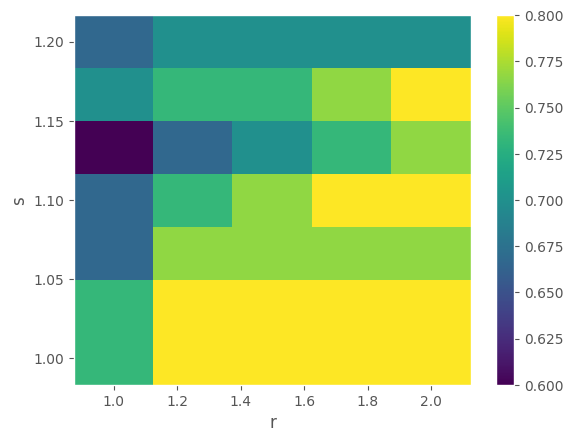

In [48]:
# visualize results of parameter sweep.
fig,ax = plt.subplots()
cax = ax.pcolor(rvalues, svalues, results.T)
ax.set(xlabel='r', ylabel='s')
fig.colorbar(cax)

In [50]:
results.T

array([[0.73333333, 0.8       , 0.8       , 0.8       , 0.8       ],
       [0.73333333, 0.8       , 0.8       , 0.8       , 0.8       ],
       [0.66666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667],
       [0.66666667, 0.73333333, 0.76666667, 0.8       , 0.8       ],
       [0.6       , 0.66666667, 0.7       , 0.73333333, 0.76666667],
       [0.7       , 0.73333333, 0.73333333, 0.76666667, 0.8       ],
       [0.66666667, 0.7       , 0.7       , 0.7       , 0.7       ]])